In [83]:
%matplotlib inline
from CartPole import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# Task 2

In [2]:
plot_path = 'plots/Task2/'
index_to_variable = {0 : 'cart_location', 1 : 'cart_velocity', 2 : 'pole_angle', 3 : 'pole_velocity', 4 : 'action'}
index_pair_list = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3],[0,4],[1,4],[2,4],[3,4]]
no_samples = 20
x_range_for_index = {0 : np.linspace(-5,5,no_samples), 1 : np.linspace(-10,10,no_samples), 
                     2 : np.linspace(-np.pi,np.pi,no_samples), 3 : np.linspace(-15,15,no_samples), 
                     4 : np.linspace(-20,20,no_samples)}

lam = 0.00001
n = 2000
no_RBC = 320
train_proportion = 0.8

In [3]:
def kernel(X, X_dash, sigma):

    if type(X) == list: X = np.array(X)
    if type(X_dash) == list: X_dash = np.array([X_dash])
    
    try:
        squared_numerator = np.array([(X[i]-X_dash[i])**2 if i != 2  else (np.sin((X[i]-X_dash[i])/2))**2 for i in range(5)])
    except:
        print(X, X_dash, '<------------ fix this')
    return np.exp(-np.sum(np.divide(squared_numerator, 2*np.square(sigma))))

In [4]:
def generate_K(X, M, sigma, kernel=kernel):
    if type(M) != list: M = np.array(M)
        
    for i,x_location in enumerate(X):
        K_row = np.array([kernel(x_location, RBF_x, sigma) for RBF_x in X[M]])
        try:
            KnM = np.vstack((KnM, K_row))
        except:
#             print('first row of K: {} <---------------------- this should only happen once'.format(K_row.shape))
            KnM = K_row
            
    return KnM

In [5]:
def train_alpha(x_train, y_train, no_RBC, sigma, kernel=kernel, lam=0.00001):
    
    M_vals = np.random.randint(0, high=n*train_proportion, size=no_RBC)
    X_i_vals = x_train[M_vals]
    KnM_ = generate_K(x_train, M_vals, sigma, kernel)
    KMM_ = generate_K(X_i_vals, [i for i in range(M_vals.size)], sigma, kernel)
    alpha = np.linalg.lstsq(np.matmul(KnM_.T, KnM_) + lam*KMM_, np.matmul(KnM_.T, y_train))[0]

#     alpha = np.linalg.lstsq(np.matmul(KnM_.T, KnM_), np.matmul(KnM_.T, y_train))[0]
#     alpha = np.matmul(np.linalg.pinv(KnM_), y_train).T
#     print('alpha.shape: {}'.format(alpha.shape))
    
    return alpha, X_i_vals

In [6]:
def predict(x_test, alpha, X_i_vals, sigma, kernel=kernel):
    
    KnM_test= [None, None]
    for X_i in X_i_vals:
        if x_test.size > 4:
            assert x_test.size % 5 == 0, 'x_test.size: ' + str(x_test.size)
            
            if x_test.ndim == 1:
                KnM_test_row = kernel(X_i, x_test, sigma=sigma)
            else:
                KnM_test_row = np.array([kernel(X_i, x_test_, sigma=sigma) for x_test_ in x_test])
            
        elif x_test.size == 4:
            if x_test.ndim > 1: x_test = x_test[0]
            KnM_test_row = kernel(X_i, x_test, sigma=sigma)
        try:
            KnM_test = np.vstack((KnM_test, KnM_test_row))
        except:
            KnM_test = KnM_test_row
    predictions = np.matmul(KnM_test.T, alpha)
    
    return predictions

In [7]:
def display_RMSE(predictions, y_test):
    targets = y_test            
    return [np.sqrt(np.mean((predictions[:,j]-targets[:,j])**2)) for j in range(4)] 

## plot convergence of model for varying no. basis functions

In [8]:
# i_range = [10, 20, 40, 80, 160, 320] # list of no. radial basis functions to try
# n_range = [500, 1000, 2000, 4000] # list of sizes of dataset to try

# fig,axs = plt.subplots(2,2,figsize=(12,9))
# for n in n_range:
#     x,y = generate_data(n)
#     x_train, y_train, x_test, y_test = x[:int(n*train_proportion)], y[:int(n*train_proportion)], x[int(n*train_proportion):], y[int(n*train_proportion):]
#     sigma = np.std(x_train, axis=0)
    
#     RMSE = None
    
#     for i in i_range:
#         alpha, X_i_vals = train_alpha(x_train, y_train, i, sigma)
#         predictions = predict(x_test, alpha, X_i_vals, sigma)
#         RMSE_ = np.array(display_RMSE(predictions, y_test))
        
#         try:
#             RMSE = np.vstack((RMSE, RMSE_))
#         except:
#             RMSE = RMSE_
#     for j in range(4):
#         axs[int(round((j+1)/4,0)),j%2].plot(i_range, RMSE[:,j], label='N = {}'.format(str(n)))
#         axs[int(round((j+1)/4,0)),j%2].legend()
#         axs[int(round((j+1)/4,0)),j%2].set_title(index_to_variable[j])
#         axs[int(round((j+1)/4,0)),j%2].set_xlabel('no. basis functions')
#         axs[int(round((j+1)/4,0)),j%2].set_ylabel('RMSE')
# fig.tight_layout()
# # plt.savefig(plot_path + 'convergence_of_non_linear_model')

## Plot model predictions vs actual values

In [34]:
x,y = generate_data(n)
x_train, y_train, x_test, y_test = x[:int(n*train_proportion)], y[:int(n*train_proportion)], x[int(n*train_proportion):], y[int(n*train_proportion):]
sigma = np.std(x_train, axis=0)

# alpha, X_i_vals = train_alpha(x_train, y_train, no_RBC, sigma)
# predictions = predict(x_test, alpha, X_i_vals, sigma)

In [10]:
# fig,axs = plt.subplots(2,2,figsize=(12,9))
# for j in range(4):
#     ul = max(max(predictions[:,j]), max(y_test[:,j]))
#     ll = min(min(predictions[:,j]), min(y_test[:,j]))
#     axs[int(round((j+1)/4,0)),j%2].scatter(predictions[:,j], y_test[:,j])
#     axs[int(round((j+1)/4,0)),j%2].plot([ll,ul],[ll,ul], color='g')
#     axs[int(round((j+1)/4,0)),j%2].set_title(index_to_variable[j])
#     axs[int(round((j+1)/4,0)),j%2].set_xlabel('prediction')
#     axs[int(round((j+1)/4,0)),j%2].set_ylabel('actual')
    
#     fig.tight_layout()
    
# # plt.savefig(plot_path + 'prediction_accuracy_with_action')

## Plot contours for non linear model

In [11]:
# for index_pair in index_pair_list:
#     plot_y_contour_as_difference_in_x(x_test[0], index_pair, range_x_pair_finder(index_pair, x_range_for_index), 
#                                       index_to_variable, dynamics='predicted', model=predict, alpha=alpha, 
#                                       X_i_vals=X_i_vals, sigma=sigma)
# #     plt.savefig(plot_path+'contour_plot_predictions_with_action'+str(index_pair))
# #     plt.close()

## Testing different values of lambda

In [12]:
# n = 500
# x,y = generate_data(n)
# x_train, y_train, x_test, y_test = x[:int(n*train_proportion)], y[:int(n*train_proportion)], x[int(n*train_proportion):], y[int(n*train_proportion):]
# sigma = np.std(x_train, axis=0)
# initial_x = x_test[0]

# RMSE_data = []
# for lam in [0.1**i for i in range(7)]:
#     alpha, X_i_vals = train_alpha(x_train, y_train, 40, sigma, lam=lam)

#     prediction_history, y_history = project_x_using_model(x[0], predict, steps=10, remap_angle=False, alpha=alpha, 
#                                                            X_i_vals=X_i_vals, sigma=sigma)
#     RMSE_data.append(display_RMSE(prediction_history, y_history))
    
# RMSE_data = np.array(RMSE_data)

# fig,ax = plt.subplots(1,1,figsize=(8,6))
# for j in range(4):
#     ax.plot([0.1**i for i in range(7)], RMSE_data[:,j], label=index_to_variable[j])
# ax.legend()
# ax.set_xscale('log')
# ax.set_xlabel('lambda value')
# ax.set_ylabel('RMSE')
# ax.set_title('RMSE error for different values of lambda')
# # plt.savefig(plot_path + 'RMSE_different_lambda')

## Rollout with model prediction

In [13]:
# steps = 10

# oscillating_initial_condition = np.array([x_test[0][i] if i != 3 else np.random.uniform(5,10) for i in range(4)])
# print(oscillating_initial_condition)

# sigma = np.std(x_train, axis=0)
# alpha, X_i_vals = train_alpha(x_train, y_train, no_RBC, sigma)

# prediction_history, y_history = project_x_using_model(x_test[0], predict, steps=steps, remap_angle=False, 
#                                                       compound_predictions=False, alpha=alpha, 
#                                                       X_i_vals=X_i_vals, sigma=sigma)

# prediction_history[:,2] = np.array([_remap_angle(angle) for angle in prediction_history[:,2]])
# y_history[:,2] = np.array([_remap_angle(angle) for angle in y_history[:,2]])

# plot_prediction_vs_actual_over_time(prediction_history, y_history, title='Initial Conditions: {}'.format(x_test[0]))
# # plt.savefig(plot_path + 'model_rollout_prediction_with_action_{}_steps'.format(steps))

## Model performance scanning over 1 variable

In [14]:
# plot_y_scans(x_test[0], index_to_variable, x_range_for_index, predict, alpha=alpha, 
#              X_i_vals=X_i_vals, sigma=sigma)
# # plt.savefig(plot_path + 'model_accuracy_scan_over_1_variable_with_action')

## Introducing the loss function

In [15]:
# plt.plot(np.linspace(0,2,20), [loss([0,0,i,0]) for i in np.linspace(0,2,20)])

In [16]:
def project_loss(initial_x, steps=1):
    
    cp = CartPole()
    cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity, action = initial_x
    loss_history = [loss(initial_x[:-1])]
    y_history = np.array([initial_x])
    
    for step in range(steps):
        cp.performAction(action)
        cp.remap_angle()
        y_ = np.array([cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity, action])
        loss_ = loss(y_[:-1])
        loss_history.append(loss_)
        y_history = np.vstack((y_history, y_))
        
    
    return np.array(loss_history), y_history

In [17]:
# steps = 30
# loss_history, y_history = project_loss([0,0,0,0.5,0.0], steps = steps)

# plt.plot([i for i in range(steps+1)], loss_history)
# plt.title('loss function over initial conditions: [0,0,0,0.5]')
# plt.xlabel('time steps')
# plt.ylabel('loss')
# # plt.savefig(plot_path + 'loss_function_over_time')

In [79]:
# def plot_loss_contours(initial_x, initial_p, index_pair, range_p_pair, index_to_variable):
#     print(initial_x)
#     index_1, index_2 = index_pair
#     range_1, range_2 = range_p_pair
    
#     loss_grid = np.zeros((len(range_1),len(range_2)))
    
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
    
#     for i,value_1 in enumerate(range_1):
#         for j, value_2 in enumerate(range_2):
#             x_ = initial_x.copy()
#             p_ = initial_p.copy()
#             p_[index_1] = value_1
#             p_[index_2] = value_2
#             x_[-1] = np.dot(x_[:-1],p_)
#             y_ = np.array(move_cart(x_, steps=1, display_plots=False, remap_angle=False))
#             loss_y = loss(y_)
#             loss_x = loss(initial_x.copy())
# #             print(loss_y,loss_x,y_,x_)
#             loss_grid[i,j] = loss_y - loss_x
                
#     plt.contourf(range_1, range_2, loss_grid.T)
#     cs = ax.contourf(range_1, range_2, loss_grid.T)
#     fig.colorbar(cs, ax=ax)
#     plt.title('change in loss function')
#     plt.xlabel('$p_{}$ value'.format(index_1))
#     plt.ylabel('$p_{}$ value'.format(index_2)) 
#     print(np.max(loss_grid))


In [80]:
# for index_pair in [index_pair for index_pair in index_pair_list if 4 not in index_pair ]:
#     x_ = np.zeros(5)
#     x_[index_pair] += 0.1
#     plot_loss_contours(x_, [0,0,0,0], index_pair, [np.linspace(-10,10,10)]*2, index_to_variable)
#     plt.show()

### Optimise the linear matrix P

In [163]:
def loss_after_action_step(p, initial_x):
    action_ = np.dot(p, initial_x[:-1])
    x_ = initial_x.copy()
    x_[-1] = action_
    y_ = np.array(move_cart(x_, steps=1, display_plots=False, remap_angle=False))
    return loss(y_[2])

In [138]:
for i in np.linspace(-2.5,2.5,21):
    print(np.round(i,2), '\t', np.round(scipy.optimize.minimize(loss_after_action_step, 
                                                                np.random.randint(0,1,4), 
                                                                args=([i,np.random.uniform(-0.5,0.5),
                                                                       np.random.uniform(-0.5,0.5),
                                                                       np.random.uniform(-0.5,0.5),0]))['x'],3))

-2.5 	 [0. 0. 0. 0.]
-2.25 	 [0. 0. 0. 0.]
-2.0 	 [0. 0. 0. 0.]
-1.75 	 [0. 0. 0. 0.]
-1.5 	 [ 0.015 -0.002  0.    -0.002]
-1.25 	 [-0.409 -0.155  0.031  0.092]
-1.0 	 [0. 0. 0. 0.]
-0.75 	 [ 0.517 -0.215  0.059  0.236]
-0.5 	 [ 0.023  0.02   0.003 -0.012]
-0.25 	 [0. 0. 0. 0.]
0.0 	 [0.    1.253 1.494 1.385]
0.25 	 [0. 0. 0. 0.]
0.5 	 [0. 0. 0. 0.]
0.75 	 [ 0.656  0.096  0.194 -0.158]
1.0 	 [-0.269  0.049  0.008  0.098]
1.25 	 [ 0.337 -0.091  0.018  0.094]
1.5 	 [-0.274 -0.029  0.035 -0.08 ]
1.75 	 [0. 0. 0. 0.]
2.0 	 [0. 0. 0. 0.]
2.25 	 [-0.077 -0.003  0.004 -0.017]
2.5 	 [0. 0. 0. 0.]


for initial_x values any larger than roughly 0.5, the function converges on a local minimum of [0,0,0,0].

for initial_x values in the range -0.5, 0.5, the function converges on suitable values of p.

Crucially, the P values found depend heavily on the initial_x values

[ 0.          0.         70.39494013  0.        ]
0.001
0.00010864283861995226
-0.0026727264852949837
-0.006110413129294779
-0.0054768660920339485
0.005891971403338854
0.028698441318859656
0.04531204711275509
0.015882001449692353
-0.0964421933506181


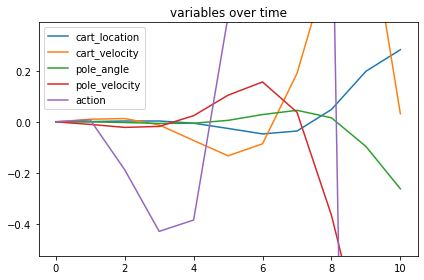

In [203]:
initial_x = [0,0,0.01,0,0]
steps = 10

p = scipy.optimize.minimize(loss_after_action_step, 
                        np.random.randint(0,1,4), 
                        args=(initial_x))['x']
print(p)


x_ = [0,0,0.001,0,0]
x_history = [x_.copy()]
for step in range(steps):
    print(x_[2])
    action_ = np.dot(p, x_[:-1])
    x_[-1] = action_
    x_ = np.array(move_cart(x_, steps=1, display_plots=False, remap_angle=False))  
    x_history.append(x_)
    
x_history = np.array(x_history)

fig, ax = plt.subplots(1, 1)

for i in range(5):
    ax.plot([i for i in range(steps+1)], [x[i] for x in x_history], label=index_to_variable[i])
ax.set_title('variables over time')
ax.legend()
ax.set_ylim(2*np.min(x_history[:,2]),0.3+2*np.max(x_history[:,2]))
fig.tight_layout()

Kind of stabilises